### Load required libraries

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load data

In [71]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z']

df = pd.read_csv('./data/HAR/WISDM/WISDM.csv', index_col=0)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### Inspect Data

In [72]:
df['activity'].value_counts(normalize=True)

Walking       0.386447
Jogging       0.311578
Upstairs      0.111882
Downstairs    0.091447
Sitting       0.054579
Standing      0.044067
Name: activity, dtype: float64

In [73]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'], dtype='object')

### Data preprocessing

In [145]:
from pandas import DataFrame

sitting = df[df.activity=='Sitting'].sample(4499)
jogging = df[df.activity=='Jogging'].sample(4500)

sitting.iloc[:,1] = 0;
jogging.iloc[:,1] = 1;

sitting = sitting[['X','Y','Z', 'activity']]
jogging = jogging[['X','Y','Z', 'activity']]

resample = pd.concat([sitting, jogging])
resample

,X,Y,Z,activity
221673,3.17,9.30,1.225831,0
542268,5.24,4.99,7.120000,0
581580,-4.06,3.30,8.500000,0
581348,-3.91,3.06,8.730000,0
509156,6.55,2.41,6.510000,0
...,...,...,...,...
965346,-16.02,-3.21,7.930000,1
139919,3.68,-2.22,2.982856,1
819155,19.23,11.22,-1.040000,1
27259,15.70,3.45,5.434519,1


### Train/Test split

In [295]:
X_train, X_test = train_test_split(resample, test_size=0.2, random_state=42)
X_train = X_train[X_train.activity == 0]
X_train, y_train = X_train.drop(['activity'], axis=1),X_train['activity'].values

y_test = X_test['activity'].values
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (3618, 3)
X_test shape: (1800, 3)


### Visualize the data with TSNE and PCA

In [32]:
x = resample.drop(['activity'],axis=1).values
y = resample['activity'].values

SEED = 42

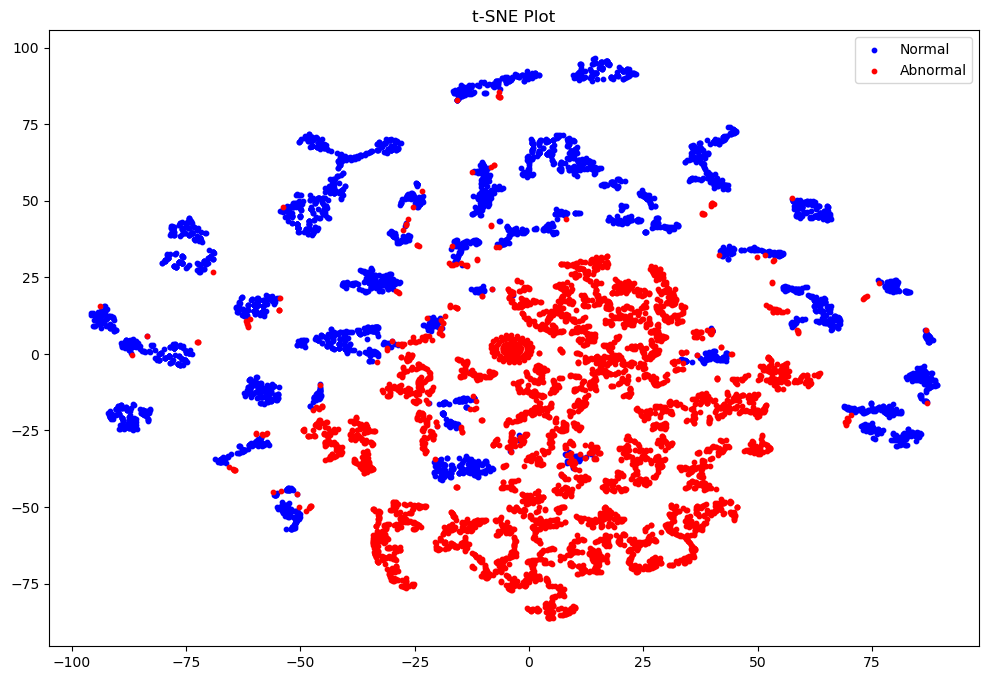

In [37]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('t-SNE Plot')
plt.legend()
plt.show()

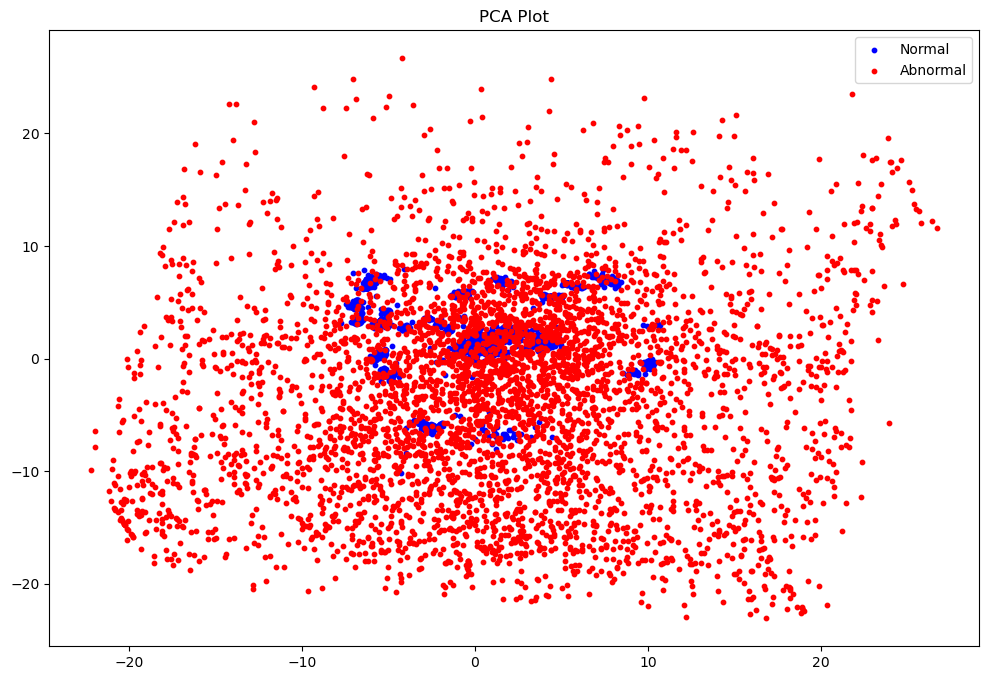

In [38]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('PCA Plot')
plt.legend()
plt.show()

### Normalize Data

In [296]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

In [297]:
time_step = 3
step = 1

def split_sequences(Xdata, ydata, time_steps, steps):
    X, y = list(), list()
    length = len(ydata)
    for i in range(0, length, steps):

        end_ix = i + time_steps

        if end_ix > length:
            break

        seq_x, seq_y = Xdata[i:end_ix], ydata[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [298]:
X_train, y_train = split_sequences(X_train, y_train, time_step, step)
X_test, y_test = split_sequences(X_test, y_test, time_step, step)

In [299]:
X_train

array([[[-1.33,  3.53,  9.43],
        [ 8.24, -2.34,  4.18],
        [ 2.26,  2.49,  8.88]],

       [[ 8.24, -2.34,  4.18],
        [ 2.26,  2.49,  8.88],
        [ 1.42, -0.04,  9.7 ]],

       [[ 2.26,  2.49,  8.88],
        [ 1.42, -0.04,  9.7 ],
        [ 8.96, -1.08,  2.03]],

       ...,

       [[-4.14,  3.3 ,  8.58],
        [ 1.46,  0.  ,  9.62],
        [ 2.91,  2.26,  8.85]],

       [[ 1.46,  0.  ,  9.62],
        [ 2.91,  2.26,  8.85],
        [-0.46, -1.8 ,  9.47]],

       [[ 2.91,  2.26,  8.85],
        [-0.46, -1.8 ,  9.47],
        [ 7.44,  2.3 ,  6.51]]])

In [300]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3616, 3, 3), (3616,), (1798, 3, 3), (1798,))

### LSTM AutoEncoder Model

In [301]:
input_dim = X_train.shape[1]

input_layer = Input(shape=( X_train.shape[1],  X_train.shape[2]))

encoder = LSTM(2, activation="relu", return_sequences=False)(input_layer)
encoder = RepeatVector( X_train.shape[1])(encoder)
decoder = LSTM(2, activation="relu", return_sequences=True)(encoder)
decoder = TimeDistributed(Dense(X_train.shape[2]))(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3, 3)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 2)                 48        
                                                                 
 repeat_vector_10 (RepeatVe  (None, 3, 2)              0         
 ctor)                                                           
                                                                 
 lstm_21 (LSTM)              (None, 3, 2)              40        
                                                                 
 time_distributed_10 (TimeD  (None, 3, 3)              9         
 istributed)                                                     
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.0

In [302]:
epochs = 200
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./pth/WISDM_LSTM_AE.h5", verbose=0, save_best_only=True)

In [303]:
history = autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/200
102/102 [==============================] - 6s 13ms/step - loss: 32.0241 - accuracy: 0.6838 - val_loss: 31.7307 - val_accuracy: 0.7063
Epoch 2/200
102/102 [==============================] - 1s 6ms/step - loss: 31.3496 - accuracy: 0.6885 - val_loss: 31.0543 - val_accuracy: 0.7063
Epoch 3/200
102/102 [==============================] - 1s 6ms/step - loss: 30.7038 - accuracy: 0.6885 - val_loss: 30.4055 - val_accuracy: 0.7063
Epoch 4/200
102/102 [==============================] - 1s 6ms/step - loss: 30.0839 - accuracy: 0.6885 - val_loss: 29.7750 - val_accuracy: 0.7063
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 29.4895 - accuracy: 0.6891 - val_loss: 29.1692 - val_accuracy: 0.7155
Epoch 6/200
102/102 [==============================] - 1s 6ms/step - loss: 28.9189 - accuracy: 0.6890 - val_loss: 28.5783 - val_accuracy: 0.7155
Epoch 7/200
102/102 [==============================] - 1s 6ms/step - loss: 28.3681 - accuracy: 0.6889 - val_loss: 28.0199 - val_a

102/102 [==============================] - 1s 7ms/step - loss: 16.1943 - accuracy: 0.6959 - val_loss: 15.4742 - val_accuracy: 0.7182
Epoch 58/200
102/102 [==============================] - 1s 6ms/step - loss: 16.1103 - accuracy: 0.6959 - val_loss: 15.4599 - val_accuracy: 0.7182
Epoch 59/200
102/102 [==============================] - 1s 6ms/step - loss: 16.0327 - accuracy: 0.6960 - val_loss: 15.3061 - val_accuracy: 0.7182
Epoch 60/200
102/102 [==============================] - 1s 6ms/step - loss: 15.9609 - accuracy: 0.6958 - val_loss: 15.2339 - val_accuracy: 0.7182
Epoch 61/200
102/102 [==============================] - 1s 6ms/step - loss: 15.8836 - accuracy: 0.6959 - val_loss: 15.1852 - val_accuracy: 0.7182
Epoch 62/200
102/102 [==============================] - 1s 5ms/step - loss: 15.8123 - accuracy: 0.6959 - val_loss: 15.0934 - val_accuracy: 0.7182
Epoch 63/200
102/102 [==============================] - 1s 5ms/step - loss: 15.7507 - accuracy: 0.6959 - val_loss: 15.0150 - val_accuracy

102/102 [==============================] - 1s 8ms/step - loss: 14.1667 - accuracy: 0.6885 - val_loss: 13.5931 - val_accuracy: 0.7063
Epoch 114/200
102/102 [==============================] - 1s 5ms/step - loss: 14.1469 - accuracy: 0.6885 - val_loss: 13.5700 - val_accuracy: 0.7063
Epoch 115/200
102/102 [==============================] - 1s 5ms/step - loss: 14.1295 - accuracy: 0.6885 - val_loss: 13.5606 - val_accuracy: 0.7063
Epoch 116/200
102/102 [==============================] - 1s 5ms/step - loss: 14.1148 - accuracy: 0.6885 - val_loss: 13.5494 - val_accuracy: 0.7063
Epoch 117/200
102/102 [==============================] - 1s 5ms/step - loss: 14.1011 - accuracy: 0.6885 - val_loss: 13.5383 - val_accuracy: 0.7063
Epoch 118/200
102/102 [==============================] - 1s 5ms/step - loss: 14.0840 - accuracy: 0.6885 - val_loss: 13.5213 - val_accuracy: 0.7063
Epoch 119/200
102/102 [==============================] - 1s 7ms/step - loss: 14.0625 - accuracy: 0.6885 - val_loss: 13.5021 - val_ac

Epoch 169/200
102/102 [==============================] - 1s 5ms/step - loss: 12.4941 - accuracy: 0.6885 - val_loss: 11.9406 - val_accuracy: 0.7063
Epoch 170/200
102/102 [==============================] - 1s 5ms/step - loss: 12.4119 - accuracy: 0.6885 - val_loss: 11.8820 - val_accuracy: 0.7063
Epoch 171/200
102/102 [==============================] - 1s 5ms/step - loss: 12.3341 - accuracy: 0.6885 - val_loss: 11.8153 - val_accuracy: 0.7063
Epoch 172/200
102/102 [==============================] - 1s 5ms/step - loss: 12.2695 - accuracy: 0.6885 - val_loss: 11.7617 - val_accuracy: 0.7063
Epoch 173/200
102/102 [==============================] - 1s 5ms/step - loss: 12.2134 - accuracy: 0.6885 - val_loss: 11.7161 - val_accuracy: 0.7063
Epoch 174/200
102/102 [==============================] - 1s 7ms/step - loss: 12.1625 - accuracy: 0.6885 - val_loss: 11.6658 - val_accuracy: 0.7063
Epoch 175/200
102/102 [==============================] - 1s 7ms/step - loss: 12.1203 - accuracy: 0.6885 - val_loss: 11

In [304]:
autoencoder = load_model("./pth/WISDM_LSTM_AE.h5")

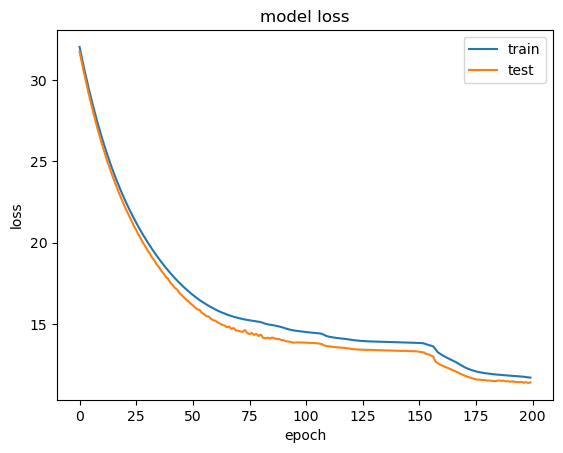

In [305]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [306]:
flattenN = X_test.shape[1]*X_test.shape[2]

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test.reshape(-1,flattenN)- predictions.reshape(-1,flattenN),2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

57/57 [==============================] - 1s 2ms/step


,reconstruction_error,true_class
count,1798.000000,1798.000000
mean,47.732762,0.510567
std,36.477562,0.500027
min,1.814136,0.000000
25%,18.861985,0.000000
50%,40.087909,1.000000
75%,66.432933,1.000000
max,298.490255,1.000000


In [345]:
threshold = 31

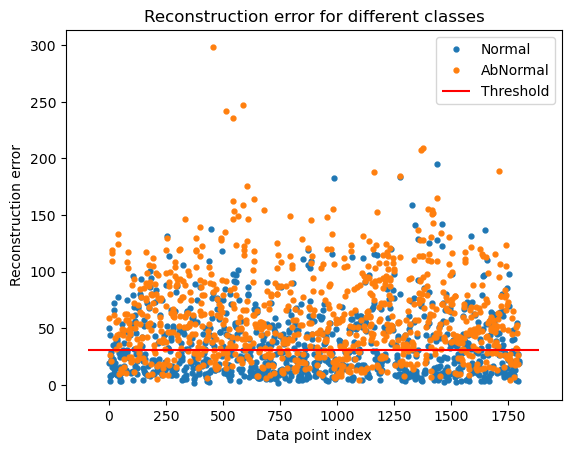

In [346]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "AbNormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

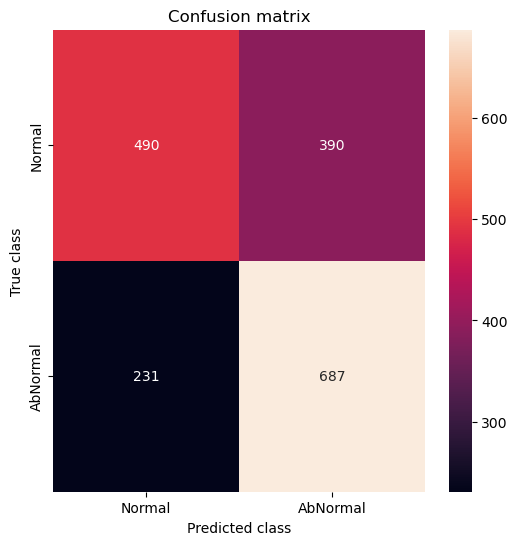

In [347]:
LABELS = ["Normal", "AbNormal"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [348]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.6546162402669633
Precision : 0.637883008356546
Recall : 0.7483660130718954
F1 : 0.6887218045112782


### Visualize the latent space

In [349]:
inp_layer = autoencoder.input
out_layer = autoencoder.layers[1].output

encoder = Model(inputs=inp_layer, outputs=out_layer)
encoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3, 3)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 2)                 48        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


57/57 [==============================] - 0s 2ms/step


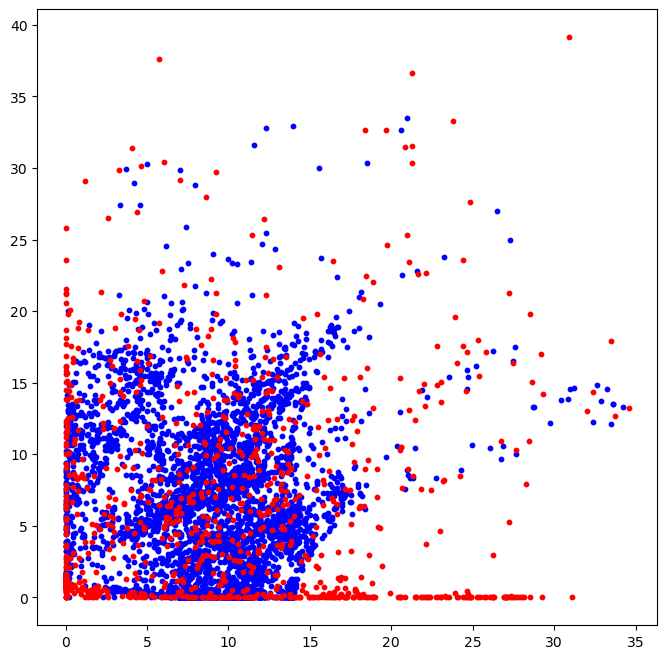

In [350]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[2]==0][0],encoded_df[encoded_df[2]==0][1], color='blue', label='Normal', s=10)
plt.scatter(encoded_df[encoded_df[2]==1][0],encoded_df[encoded_df[2]==1][1], color='red', label='AbNormal', s=10);